In [1]:
import pandas as pd
import statistics
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import operator

<h3>Reading the datasets using pandas</h3>

In [2]:
animes = pd.read_csv('anime.csv')
ratings = pd.read_csv('rating.csv')

<h3>Sample data from the two datasets</h3>

In [3]:
ratings = ratings[ratings.rating != -1]
ratings.head()

,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10


In [4]:
animes.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


<h3>Statistical Inference between the users and the animes that they have rated.</h3>

<AxesSubplot:>

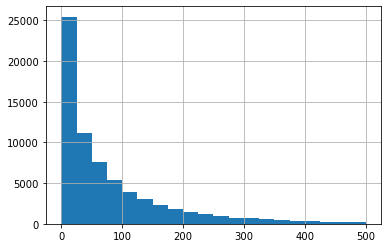

In [5]:
len(ratings)
len(ratings['user_id'].unique())
len(animes['anime_id'].unique())
ratings_per_user = ratings.groupby('user_id')['rating'].count()
statistics.mean(ratings_per_user.tolist())
%matplotlib inline
ratings_per_user.hist(bins=20, range=(0,500))

<AxesSubplot:>

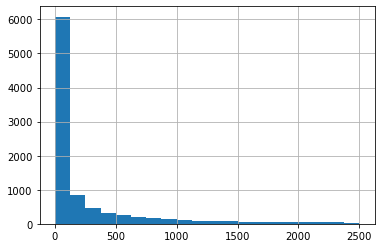

In [6]:
ratings_per_anime = ratings.groupby('anime_id')['rating'].count()
statistics.mean(ratings_per_anime.tolist())
%matplotlib inline
ratings_per_anime.hist(bins=20, range=(0,2500))

<h3>Filtering out animes with less than 1000 ratings. Animes with lesser ratings may not be relevant on a larger scale as they have a narrower audience.</h3>

In [7]:
ratings_per_anime_df = pd.DataFrame(ratings_per_anime)
filtered_ratings_per_anime_df = ratings_per_anime_df[ratings_per_anime_df.rating >= 1000]
popular_anime = filtered_ratings_per_anime_df.index.tolist()

<h3>Filtering out users who have not given more than 500 ratings. Such users have watched less variety of animes and thus may not be relevant on a larger scale.</h3>

In [8]:
ratings_per_user_df = pd.DataFrame(ratings_per_user)
filtered_ratings_per_user_df = ratings_per_user_df[ratings_per_user_df.rating >= 500]
prolific_users = filtered_ratings_per_user_df.index.tolist()

In [9]:
filtered_ratings = ratings[ratings.anime_id.isin(popular_anime)]
filtered_ratings = ratings[ratings.user_id.isin(prolific_users)]
len(filtered_ratings)

1005314

<h3>Data is transformed into a readable matrix form.</h3>

In [10]:
rating_matrix = filtered_ratings.pivot_table(index='user_id', columns='anime_id', values='rating')
rating_matrix = rating_matrix.fillna(0)
rating_matrix.head()

anime_id,1,5,6,7,8,15,16,17,18,19,...,34238,34239,34240,34252,34283,34324,34325,34349,34367,34475
user_id,,,,,,,,,,,,,,,,,,,,,
226,8.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
294,7.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
392,7.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
446,9.0,8.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,...,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h3>User based collaborative filtering predicts the items that a user might like on the basis of ratings given to that item by other users who have similar taste with that of the target user. The below function finds users similar to the target user mentioned as a parameter of the function.</h3>

In [12]:
def similar_users(user_id, matrix, k=3):
    # create a df of just the current user
    user = matrix[matrix.index == user_id]
    
    # and a df of all other users
    other_users = matrix[matrix.index != user_id]
    
    # calc cosine similarity between user and each other user
    similarities = cosine_similarity(user,other_users)[0].tolist()
    
    # create list of indices of these users
    indices = other_users.index.tolist()
    
    # create key/values pairs of user index and their similarity
    index_similarity = dict(zip(indices, similarities))
    
    # sort by similarity
    index_similarity_sorted = sorted(index_similarity.items(), key=operator.itemgetter(1))
    index_similarity_sorted.reverse()
    
    # grab k users off the top
    top_users_similarities = index_similarity_sorted[:k]
    users = [u[0] for u in top_users_similarities]
    
    return users
    
current_user = 226
similar_user_indices = similar_users(current_user, rating_matrix)
print(similar_user_indices)

[30773, 39021, 45603]


<h3>The below function finds the missing animes in the target users watchlist from the watchlists of the users who are similar to the target user found using the function above. Then it displays the top results as the recommendations.</h3>

In [13]:
def recommend_item(user_index, similar_user_indices, matrix, items=5):
    # load vectors for similar users
    similar_users = matrix[matrix.index.isin(similar_user_indices)]
    # calc avg ratings across the 3 similar users
    similar_users = similar_users.mean(axis=0)
    # convert to dataframe so its easy to sort and filter
    similar_users_df = pd.DataFrame(similar_users, columns=['mean'])
    
    
    # load vector for the current user
    user_df = matrix[matrix.index == user_index]
    # transpose it so its easier to filter
    user_df_transposed = user_df.transpose()
    # rename the column as 'rating'
    user_df_transposed.columns = ['rating']
    # remove any rows without a 0 value. Anime not watched yet
    user_df_transposed = user_df_transposed[user_df_transposed['rating']==0]
    # generate a list of animes the user has not seen
    animes_unseen = user_df_transposed.index.tolist()
    
    # filter avg ratings of similar users for only anime the current user has not seen
    similar_users_df_filtered = similar_users_df[similar_users_df.index.isin(animes_unseen)]
    # order the dataframe
    similar_users_df_ordered = similar_users_df.sort_values(by=['mean'], ascending=False)
    # grab the top n anime   
    top_n_anime = similar_users_df_ordered.head(items)
    top_n_anime_indices = top_n_anime.index.tolist()
    # lookup these anime in the other dataframe to find names
    anime_information = animes[animes['anime_id'].isin(top_n_anime_indices)]
    
    return anime_information #items

recommend_item(226, similar_user_indices, rating_matrix)

,anime_id,name,genre,type,episodes,rating,members
6,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855
39,12365,Bakuman. 3rd Season,"Comedy, Drama, Romance, Shounen",TV,25,8.71,133620
87,10030,Bakuman. 2nd Season,"Comedy, Drama, Romance, Shounen",TV,25,8.53,151561
131,4224,Toradora!,"Comedy, Romance, School, Slice of Life",TV,25,8.45,633817
184,7674,Bakuman.,"Comedy, Romance, Shounen",TV,25,8.35,246899
